# Code for Fig. SM6

In [1]:
%load_ext autoreload
%autoreload 1
%aimport general_functions

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from general_functions import (compute_energies, g0_fun,
                               check_convergence, plot_band_structure,
                               lattice_sites, compute_hamiltonian_real_space)

To compute the band structure of the bilayer configuration, we compute the energy of a single band $\omega_\mathbf{k}$. Then the two bands of the total system can be computed as $\omega_\mathbf{k} \pm |J_\mathbf{k}|$, where the coupling term can be computed in the real space as

\begin{equation}
    J_\mathbf{k} = \langle \psi_\mathbf{k}^{(A)}(\mathbf{r})|H(\mathbf{r})|\psi_\mathbf{k}^{(B)}(\mathbf{r})\rangle
\end{equation}

## Shifted bilayer

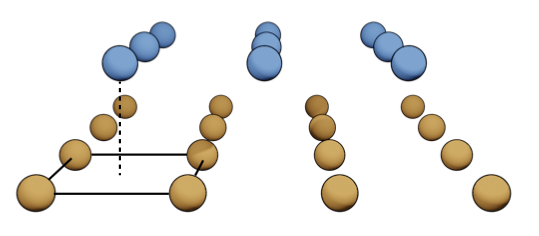

In [3]:
pol_lat = [np.array([[1, 1, 0]]).T / np.sqrt(2)]

d = 1
lambda0 = d / 0.3
k0 = 2 * np.pi / lambda0

shift = np.array([0.5, 0.5, 0.1]) * d

aho = 0.1 * d  # Renormalization parameter

nmax = 9  # Number of reciprocal lattice in the summatory

# Reciprocal lattice vectors
b1 = 2 * np.pi / d * np.array([1, 0])
b2 = 2 * np.pi / d * np.array([0, 1])

A = d ** 2  # Area of unit cell in real space

G0 = g0_fun(k0, aho)  # Renormalizated Green function in k = 0

N_x = 51
N_y = N_x
x_pos_A = (np.arange(0, N_x) - N_x / 2 + d / 2)
y_pos_A = (np.arange(0, N_y) - N_y / 2 + d / 2)

x_pos_A, y_pos_A = np.meshgrid(x_pos_A, y_pos_A)
z_pos_A = x_pos_A * 0

x_pos_B = shift[0] + x_pos_A 
y_pos_B = shift[1] + y_pos_A 
z_pos_B = shift[2] + z_pos_A 

x_pos_A = x_pos_A.flatten()
y_pos_A = y_pos_A.flatten()
z_pos_A = z_pos_A.flatten()
n_A = len(x_pos_A)

x_pos_B = x_pos_B.flatten()
y_pos_B = y_pos_B.flatten()
z_pos_B = z_pos_B.flatten()
n_B = len(x_pos_B)

x_pos = np.append(x_pos_A, x_pos_B)
y_pos = np.append(y_pos_A, y_pos_B)
z_pos = np.append(z_pos_A, z_pos_B)

r_pos = [x_pos, y_pos, z_pos]

In [4]:
n = 201  # Number of momentum to evalueate in each direction (total sites is N = n²)
k_x = (np.arange(-n // 2, n // 2) + 1) / (n // 2) * np.pi / d
k_x, k_y = [x.flatten() for x in np.meshgrid(k_x, k_x)]

k = np.vstack((k_x, k_y)).transpose()  # Momentum at which compute the bands
J, Gamma = compute_energies(b1, b2, A, nmax, k0, aho, k, G0=G0, polarizations=pol_lat)  # Compute the energy in the given momentums

omega_k = (J - 1j / 2 * Gamma).reshape((n, n))

Hamiltonian = compute_hamiltonian_real_space(r_pos, k0, pol_lat[0])

In [5]:
mode_A = np.zeros((1, n_A + n_B), dtype=complex)
mode_B = np.zeros((1, n_A + n_B), dtype=complex)

# Perform a discrete Fourier transform
mode_r_A = np.tensordot(k_x, x_pos[:n_A], axes=0) + np.tensordot(k_y, y_pos[:n_A], axes=0)
mode_r_A = np.exp(-1j * mode_r_A) / np.sqrt(np.size(x_pos[:n_A]))

mode_r_B = np.tensordot(k_x, x_pos[n_A:], axes=0) + np.tensordot(k_y, y_pos[n_A:], axes=0)
mode_r_B = np.exp(-1j * mode_r_B) / np.sqrt(np.size(x_pos[n_A:]))

mode_A = np.zeros((n ** 2, n_A + n_B), dtype=complex)
mode_A[:, :n_A] = mode_r_A

mode_B = np.zeros((n ** 2, n_A + n_B), dtype=complex)
mode_B[:, n_A:] = mode_r_B

J = np.sum(mode_A.conj() * (Hamiltonian @ mode_B.T).T, axis=-1).reshape((n, n))
        
energies_k = [omega_k + np.abs(J), omega_k - np.abs(J)]

del mode_A, mode_B, mode_r_A, mode_r_B, Hamiltonian, J  # Free RAM space

In [6]:
bands = [None] * np.shape(energies_k)[0]

for i in range(np.shape(energies_k)[0]):
    
    energy_temp = energies_k[i]
    
    band = np.zeros(3 * (n // 2), dtype=complex)

    for j in range(n // 2):  # Iterate over the momentums between symmetry points
        band[j] = energy_temp[-1 - j, -1 -j]  # M -> Gamma
        band[(n // 2) + j] = energy_temp[(n // 2), (n // 2) + j]  # Gamma -> X
        band[2 * (n // 2) + j] = energy_temp[(n // 2) + j, -1]  # X -> M
        
    bands[i] = band

n_bands = len(bands)
bands = np.array(bands).T
J_band = np.real(bands)
Gamma_band = -2 * np.imag(bands)

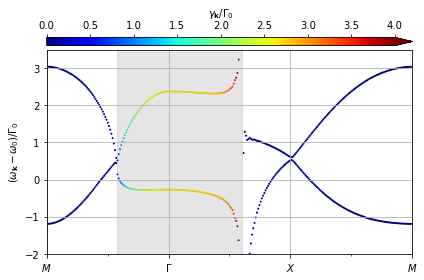

In [7]:
limit_sup = 3.5
limit_inf = -2

fig, ax1 = plt.subplots()

light = [-k0 / np.pi / np.sqrt(2), k0 / np.pi]
points_label = [r'$M$', r'$\Gamma$', r'$X$', r'$M$']

plot_band_structure(fig, ax1, J_band, Gamma_band, points_label, limit_inf=limit_inf, limit_sup=limit_sup,
                    label_cbar=r'$\gamma_\mathbf{k}/\Gamma_0$',
                    cbar_norm=4, limit_light=light)

fig.tight_layout()

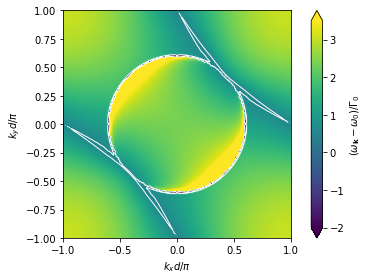

In [8]:
fig, ax = plt.subplots()

index = 0
J_plot = np.real(energies_k[index]).reshape((n, n))
    
im = ax.imshow(J_plot, extent=(-1, 1, -1, 1), vmin=limit_inf, vmax=limit_sup, origin='lower')
    
contours = ax.contour(k_x.reshape((n, n)) / np.pi, k_y.reshape((n, n)) / np.pi, J_plot,
                      [J_plot[n // 2, -1]], colors='w', linewidths=1)
      
ax.set_xlabel(r'$k_xd / \pi$')
ax.set_ylabel(r'$k_yd / \pi$')
    
circle = plt.Circle((0, 0), k0 / np.pi , color='w', fill=False, ls='--', alpha=0.5, lw=1)
ax.add_artist(circle)

cbar = plt.colorbar(im, ax=ax, extend='both')
cbar.set_label(r'$(\omega_\mathbf{k} - \omega_0)/\Gamma_0$')

fig.tight_layout()

## Stack bilayer

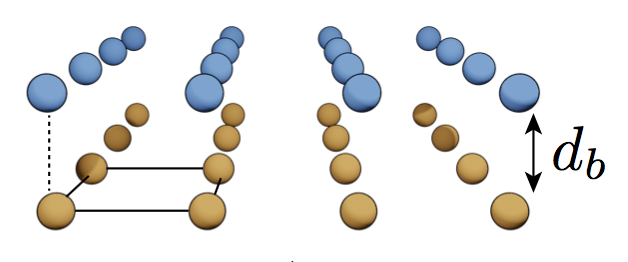

In [9]:
pol_lat = [np.array([[1, 1, 0]]).T / np.sqrt(2)]

d = 1
lambda0 = d / 0.3
k0 = 2 * np.pi / lambda0

shift = np.array([0, 0, 1]) * d

aho = 0.1 * d  # Renormalization parameter

nmax = 9  # Number of reciprocal lattice in the summatory

# Reciprocal lattice vectors
b1 = 2 * np.pi / d * np.array([1, 0])
b2 = 2 * np.pi / d * np.array([0, 1])

A = d ** 2  # Area of unit cell in real space

G0 = g0_fun(k0, aho)  # Renormalizated Green function in k = 0

N_x = 51
N_y = N_x
x_pos_A = (np.arange(0, N_x) - N_x / 2 + d / 2)
y_pos_A = (np.arange(0, N_y) - N_y / 2 + d / 2)

x_pos_A, y_pos_A = np.meshgrid(x_pos_A, y_pos_A)
z_pos_A = x_pos_A * 0

x_pos_B = shift[0] + x_pos_A
y_pos_B = shift[1] + y_pos_A
z_pos_B = shift[2] + z_pos_A

x_pos_A = x_pos_A.flatten()
y_pos_A = y_pos_A.flatten()
z_pos_A = z_pos_A.flatten()
n_A = len(x_pos_A)

x_pos_B = x_pos_B.flatten()
y_pos_B = y_pos_B.flatten()
z_pos_B = z_pos_B.flatten()
n_B = len(x_pos_B)

x_pos = np.append(x_pos_A, x_pos_B)
y_pos = np.append(y_pos_A, y_pos_B)
z_pos = np.append(z_pos_A, z_pos_B)

r_pos = [x_pos, y_pos, z_pos]

In [10]:
n = 201  # Number of momentum to evalueate in each direction (total sites is N = n²)
k_x = (np.arange(-n // 2, n // 2) + 1) / (n // 2) * np.pi / d
k_x, k_y = [x.flatten() for x in np.meshgrid(k_x, k_x)]

k = np.vstack((k_x, k_y)).transpose()  # Momentum at which compute the bands
J, Gamma = compute_energies(b1, b2, A, nmax, k0, aho, k, G0=G0, polarizations=pol_lat)  # Compute the energy in the given momentums

omega_k = (J - 1j / 2 * Gamma).reshape((n, n))

Hamiltonian = compute_hamiltonian_real_space(r_pos, k0, pol_lat[0])

In [11]:
mode_A = np.zeros((1, n_A + n_B), dtype=complex)
mode_B = np.zeros((1, n_A + n_B), dtype=complex)

mode_r_A = np.tensordot(k_x, x_pos[:n_A], axes=0) + np.tensordot(k_y, y_pos[:n_A], axes=0)
mode_r_A = np.exp(-1j * mode_r_A) / np.sqrt(np.size(x_pos[:n_A]))

mode_r_B = np.tensordot(k_x, x_pos[n_A:], axes=0) + np.tensordot(k_y, y_pos[n_A:], axes=0)
mode_r_B = np.exp(-1j * mode_r_B) / np.sqrt(np.size(x_pos[n_A:]))

mode_A = np.zeros((n ** 2, n_A + n_B), dtype=complex)
mode_A[:, :n_A] = mode_r_A

mode_B = np.zeros((n ** 2, n_A + n_B), dtype=complex)
mode_B[:, n_A:] = mode_r_B

J = (np.sum(mode_A.conj() * (Hamiltonian @ mode_B.T).T, axis=-1)).reshape((n, n))
        
energies_k = [omega_k + np.abs(J), omega_k - np.abs(J)]

del mode_A, mode_B, mode_r_A, mode_r_B, Hamiltonian, J

In [12]:
bands = [None] * np.shape(energies_k)[0]

for i in range(np.shape(energies_k)[0]):
    
    energy_temp = energies_k[i]
    
    band = np.zeros(3 * (n // 2), dtype=complex)

    for j in range(n // 2):  # Iterate over the momentums between symmetry points
        band[j] = energy_temp[-1 - j, -1 -j]  # M -> Gamma
        band[(n // 2) + j] = energy_temp[(n // 2), (n // 2) + j]  # Gamma -> X
        band[2 * (n // 2) + j] = energy_temp[(n // 2) + j, -1]  # X -> M
        
    bands[i] = band

n_bands = len(bands)
bands = np.array(bands).T
J_band = np.real(bands)
Gamma_band = -2 * np.imag(bands)

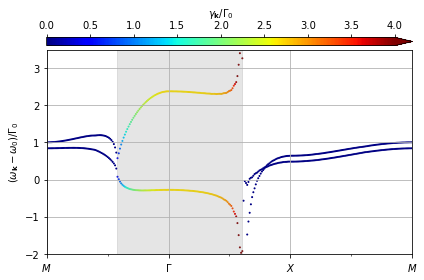

In [13]:
limit_sup = 3.5
limit_inf = -2

fig, ax1 = plt.subplots()

light = [-k0 / np.pi / np.sqrt(2), k0 / np.pi]
points_label = [r'$M$', r'$\Gamma$', r'$X$', r'$M$']

plot_band_structure(fig, ax1, J_band, Gamma_band, points_label, limit_inf=limit_inf, limit_sup=limit_sup,
                    label_cbar=r'$\gamma_\mathbf{k}/\Gamma_0$',
                    cbar_norm=4, limit_light=light)

fig.tight_layout()

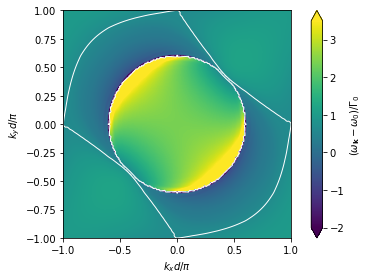

In [14]:
fig, ax = plt.subplots()

index = 0
J_plot = np.real(energies_k[index]).reshape((n, n))
    
im = ax.imshow(J_plot, extent=(-1, 1, -1, 1), vmin=limit_inf, vmax=limit_sup, origin='lower')
    
contours = ax.contour(k_x.reshape((n, n)) / np.pi, k_y.reshape((n, n)) / np.pi, J_plot,
                      [J_plot[n // 2, -1]], colors='w', linewidths=1)
      
ax.set_xlabel(r'$k_xd / \pi$')
ax.set_ylabel(r'$k_yd / \pi$')
    
circle = plt.Circle((0, 0), k0 / np.pi , color='w', fill=False, ls='--', alpha=0.5, lw=1)
ax.add_artist(circle)

cbar = plt.colorbar(im, ax=ax, extend='both')
cbar.set_label(r'$(\omega_\mathbf{k} - \omega_0)/\Gamma_0$')

fig.tight_layout()